In [58]:
from numpy.random import normal,multivariate_normal
import numpy as np
from numpy.linalg import inv
from numpy import genfromtxt

from scipy import *
from scipy.linalg import norm, pinv, det
from scipy.optimize import minimize

import csv

import cvxopt as opt
from cvxopt import matrix, solvers


import matplotlib.pyplot as plt
#import numdifftools as nd

from PIL import Image
import matplotlib.image as mping

import pandas as pd
from __future__ import division


In [59]:
#Read the data 
Xtr = genfromtxt('Xtr.csv', delimiter = ',')
d = Xtr.shape[1]

Xtr = np.delete(Xtr, (d-1), axis = 1)

Ytr = pd.read_csv('Ytr.csv')
Ytr = np.array(Ytr)
Ytr = np.delete(Ytr, (0), axis = 1)

n = Xtr.shape[0]
d = Xtr.shape[1]

#Xtr is a 5000 * 3072 dimensional matrix

#Ytr is a 5000*1 dimensional matrix


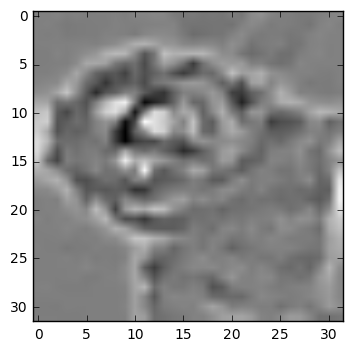

In [66]:
#The block to display images

def displayImage(image):
    plt.imshow(image, cmap='Greys')
    plt.show()

Im = Xtr[15]


Im = np.reshape(Im,(3,32,32))
I = (0.21*Im[0,:,:]+0.72*Im[1,:,:]+ 0.07*Im[2,:,:])
I = I.T
Im= Im.T+0.2
displayImage(I)


In [4]:
#Preprocessing images
#Code to tranform images into 16*16*16 dimensional histograms

#This function enforces the number C to be equal to 16 if C is greater than 16
def maxInt(NbBins, C):
    if C > NbBins-1:
        return NbBins-1
    else:
        return C


#Here we quantize the image

def quantize(Image):
    
    #Image is a 3*1024 dimensional matrix
    
    Rmax = amax(Image[0,:])
    Rmin = amin(Image[0,:])
    
    Gmax = amax(Image[1,:])
    Gmin = amin(Image[1,:])

    Bmax = amax(Image[2,:])
    Bmin = amin(Image[2,:])
    
    #Range of all chanel RGB
    Rrange = Rmax-Rmin
    Grange = Gmax-Gmin
    Brange = Bmax-Bmin
    
    #We want 16 intervals for each colour
    qR = float(Rrange)/16
    qG = float(Grange)/16
    qB = float(Brange)/16
    
    
    I= np.zeros((3,1024))
    histogram = np.zeros((16,16,16))
    #I= np.zeros((32,32,3))
    for pixel in range(1024):
            #r,g, and b respectively represent the bin number to which pixel belongs
            r = ceil(float(Im[0,pixel]-Rmin)/qR)
            g = ceil(float(Im[1,pixel]-Gmin)/qG)
            b = ceil(float(Im[2,pixel]-Bmin)/qB)
            
            #We assign new value for the new image I
            I[0,pixel] = r*qR + float(qR)/2 + Rmin
            I[1,pixel] = g*qG + float(qG)/2 + Gmin
            I[2,pixel] = b*qB + float(qB)/2 + Bmin
            
            #I[i,j,0] = ceil(float(Im[i,j,0]-Rmin)/qR)*qR + float(qR)/2 + Rmin
            #I[i,j,1] = ceil(float(Im[i,j,1]-Gmin)/qG)*qG + float(qG)/2 + Gmin
            #I[i,j,2] = ceil(float(Im[i,j,2]-Bmin)/qB)*qB + float(qB)/2 + Bmin
            
            #The histogram is updated by adding 1 to the new corresponding bin
            histogram[maxInt(16,r), 
                      maxInt(16,g), 
                      maxInt(16,b)]+=1
            
            
    return I,histogram

In [49]:
#In this block we fill the new images (encoded with 16 bins) and the histograms

X = np.zeros((Xtr.shape[0],1024))

#Histograms is a 5000 * 16 * 16 * 16 dimensional matrix

Histograms = np.zeros((Xtr.shape[0], 16,16,16))



for i in range(Xtr.shape[0]):
    Im = Xtr[i]
    Im = np.reshape(Im,(3,1024))
    I = (0.21*Im[0,:]+0.72*Im[1,:]+ 0.07*Im[2,:])
    #I, histogram = quantize(Im)
    
    X[i,:] = I
    #Histograms[i,:,:,:] = histogram 
    


In [50]:
print np.min(X[0,:])

-0.15057597


In [7]:
rho = 1
#The distance chi2 is a distance between two histograms defines as the sum over all bins
def distance_histograms_chi2(histo1, histo2):
    value = 0
    d = histo1.shape[0]
    for i in range(d):
        for j in range(d):
            for k in range(d):
                if(histo1[i,j,k] + histo2[i,j,k] != 0):
                    value += ((histo1[i,j,k] - histo2[i,j,k])**2/(histo1[i,j,k] + histo2[i,j,k]))
    return value


def distance(a, b, Image1, Image2):
    value = 0
    n = Image1.shape[0]
    for i in range(n):
        value += fabs(Image1[i]**a - Image2[i]**a)**b
    return value


#The RBF kernel suggested in the article use the gaussian kernel replacing the usual norm by the distance chi2
def Intersection_Kernel(histo1, histo2):
    return np.minimum(histo1, histo2)

def RBF_Kernel(histo1, histo2):
    return exp((-rho)*distance_histograms_chi2(histo1,histo2))

def Gaussian_Kernel_RBF(rho, a, b, Image1, Image2):
    return exp((-rho)*distance(a, b, Image1, Image2))

In [51]:
#I mmodified a bit th linear kernel to test the efficiency of a polynomial kernel. 
#Clearly we should better use a polynomial kernel with a degree greater or equal than 2
sigma =2


def Gaussian_Kernel(x,y, sigma):
    return exp((-1/2)*np.dot(x-y,x-y)/float(2*sigma))


#Return x (images) and y corresponding to label1 and label2 
def Fill_x_y_label(label1,label2):
    
    x1=X[np.where(Ytr==label1)[0],:]
    x2=X[np.where(Ytr==label2)[0],:]
    #x1=Xtr[np.where(Ytr==label1)[0],:]
    #x2=Xtr[np.where(Ytr==label2)[0],:]
    x=np.concatenate([x1,x2])
    
    
    y1=np.ones(x1.shape[0])
    y2=-1*np.ones(x2.shape[0])
    y=np.concatenate([y1,y2])
    return x,y;

#Return histograms and y corresponding to label1 and label2 
def Fill_histo_y_label(label1,label2):
    
    histo1=Histograms[np.where(Ytr==label1)[0],:,:,:]
    histo2=Histograms[np.where(Ytr==label2)[0],:,:,:]
    histo=np.concatenate([histo1,histo2], axis = 0)
    
    
    y1=np.ones(histo1.shape[0])
    y2=-1*np.ones(histo2.shape[0])
    y=np.concatenate([y1,y2])
    return histo,y;

In [54]:
#Cross-validation procedure

#NbTrain is a number of training data labeled by 1 I extract from the initial dataset
#NbTrain =400 in our case. I consider 400 data points of label 1 in tmy training set

def Fill_Training_Set(x, y, NbTrain):
    N = 2 * NbTrain
    NbTest = x.shape[0] - N
    
    yTrain = np.concatenate([y[0:NbTrain],y[500: 500 + NbTrain]])
    xTrain = np.concatenate([x[0:NbTrain,:],x[500: 500 + NbTrain,:]])
    
    KTrain=np.zeros((N,N))
    for line in range(N):
        for col in range(N):
            if (line<=col):
                value= Linear_Kernel(xTrain[line,:],xTrain[col,:])
                KTrain[col,line]=value
                KTrain[line,col]=value
    return xTrain,yTrain,KTrain


#Exactly the same with histograms
def Fill_Trainin_histo(histogramSet, y, NbTrain):
    N = 2 * NbTrain
    NbTest = histogramSet.shape[0] - N
    
    yTrain = np.concatenate([y[0:NbTrain],y[500: 500 + NbTrain]])
    histoTrain = np.concatenate([histogramSet[0:NbTrain,:,:,:],histogramSet[500: 500 + NbTrain,:,:,:]])
    
    KTrain=np.zeros((N,N))
    for line in range(N):
        print line
        for col in range(N):
            if (line<=col):
                value= Intersection_Kernel(histogramSet[line,:,:,:],histogramSet[col,:,:,:])
                KTrain[col,line]=value
                KTrain[line,col]=value
    return histoTrain,yTrain,KTrain

#Fill the test histograms
#histoTest is a 200 * 16 *16*16 dimensional matrix
def Fill_Test_Histo(histogramSet, y, NbTrain):
    yTest = np.concatenate([y[NbTrain:500],y[500 + NbTrain:1000]])
    histoTest = np.concatenate([histogramSet[NbTrain:500,:,:,:],histogramSet[500 + NbTrain:1000,:,:,:]], axis =0)
    
    return histoTest, yTest


def Fill_Test_Set(x,y,NbTrain):
    yTest = np.concatenate([y[NbTrain:500],y[500 + NbTrain:1000]])
    xTest = np.concatenate([x[NbTrain:500,:],x[500 + NbTrain:1000,:]])
    
    return xTest, yTest


#Optimization model
def Training_model(y, K, Lambda):
    P = matrix(2*K)
    q = matrix(-2*y)
    G = matrix(np.concatenate(((-1)*np.diag(y),np.diag(y))), tc='d')
    h = matrix(np.concatenate([np.zeros(y.shape), (1/(2*float(Lambda*y.shape[0])))*np.ones(y.shape)]), tc='d')
    #A = matrix(np.ones(y.shape), (1, y.shape[0]))
    A = matrix(y,(1,y.shape[0]))
    b = matrix(0.0)
    sol = solvers.qp(P,q,G,h)
    alpha = sol['x']
    print sol['status']
    alpha = np.array(alpha)
    return alpha

#Compute the new obtained label
def SVM_function(alpha, xtrain ,x_querry):
    value = 0
    for i in range(alpha.shape[0]):
        Current_Image=xtrain[i,:]
        value += alpha[i]*Linear_Kernel(x_querry,Current_Image)
    return value

def SVM_function_histo(alpha, histoTrain ,histo_querry):
    value = 0
    for i in range(alpha.shape[0]):
        Current_Image=histoTrain[i,:,:,:]
        value += alpha[i]*Intersection_Kernel(histo_querry,Current_Image)
    return np.sign(value)

def Linear_Kernel(x,y):
    #return 0.12*(np.dot(x,y))+1.05*(np.dot(x,y))**2 + 0.012 * (np.dot(x,y))**3 
    #return exp((-1/2)*np.dot(x-y,x-y)/float(2*sigma))
    return (np.dot(x,y))**2 + np.sum(np.minimum(fabs(x),fabs(y)))#+ log(1/(1-(fabs(np.dot(x,y))/(norm(x)*norm(y)))))

In [55]:
#Block to perform the optimization with the linear kernel

#Just a test for the one vs one classifier 
NbTrain = 400
Lambda=0.01
NbLabel =10
NbTest = 2*(500-NbTrain)

x,y = Fill_x_y_label(3,4)
xTrain, yTrain,KTrain = Fill_Training_Set(x, y, NbTrain)
xTest, yTest = Fill_Test_Set(x, y, NbTrain)
alpha  = Training_model(yTrain, KTrain, Lambda)


error =0
for i in range(NbTest):
    Label_found = sign(SVM_function(alpha, xTrain, xTest[i,:]))
    if(Label_found != yTest[i]):
        error += 1
Accuracy = (1-(error)/NbTest)*100.0
print 'Accuracy :', Accuracy, '%'
        

AccuracyMin  = 100
labelMin1 = 0
labelMin2 = 0


#The following block tests all duels between labels
for label1 in range(NbLabel):
    for label2 in range(NbLabel):
        if(label2 > label1):
            x,y = Fill_x_y_label(label1,label2)
            xTrain, yTrain,KTrain = Fill_Training_Set(x, y, NbTrain)
            xTest, yTest = Fill_Test_Set(x, y, NbTrain)
            alpha  = Training_model(yTrain, KTrain, Lambda)
            
            error = 0
            for i in range(NbTest):
                Label_found = sign(SVM_function(alpha, xTrain, xTest[i,:]))
                if(Label_found != yTest[i]):
                    error += 1
            Accuracy = (1-(error)/NbTest)*100.0
            print 'Accuracy :', Accuracy, '%'
            if(AccuracyMin > Accuracy):
                AccuracyMin = Accuracy
                labelMin1 = label1
                labelMin2 = label2

     pcost       dcost       gap    pres   dres
 0: -7.4646e+01 -1.2746e+02  2e+03  3e+01  1e-13
 1: -7.1499e+01 -1.1516e+02  3e+02  3e+00  1e-13
 2: -5.4036e+01 -9.3585e+01  6e+01  2e-01  1e-13
 3: -5.4075e+01 -5.8238e+01  4e+00  9e-03  9e-14
 4: -5.5409e+01 -5.5809e+01  4e-01  5e-04  9e-14
 5: -5.5562e+01 -5.5594e+01  3e-02  3e-05  9e-14
 6: -5.5575e+01 -5.5577e+01  1e-03  5e-07  1e-13
 7: -5.5576e+01 -5.5576e+01  5e-05  7e-09  9e-14
Optimal solution found.
optimal
Accuracy : 64.0 %
     pcost       dcost       gap    pres   dres
 0: -4.4013e+01 -1.0041e+02  2e+03  3e+01  7e-14
 1: -4.2438e+01 -9.2020e+01  3e+02  3e+00  9e-14
 2: -3.3852e+01 -7.3201e+01  8e+01  5e-01  7e-14
 3: -3.0776e+01 -4.0128e+01  9e+00  2e-16  5e-14
 4: -3.2259e+01 -3.3311e+01  1e+00  2e-16  5e-14
 5: -3.2552e+01 -3.2641e+01  9e-02  2e-16  6e-14
 6: -3.2583e+01 -3.2587e+01  4e-03  2e-16  6e-14
 7: -3.2585e+01 -3.2585e+01  2e-04  2e-16  6e-14
 8: -3.2585e+01 -3.2585e+01  9e-06  2e-16  6e-14
Optimal solution foun

KeyboardInterrupt: 

In [25]:
print labelMin1, labelMin2

0 1


In [56]:
#Number of observation from k-th class in training set 
Lambda = 0.009
NbTrain = 400
N = 2*NbTrain
NbLabel = 10


AlphaClassifiers = np.zeros((NbLabel,NbLabel,N))


for label1 in range(NbLabel): 
    for label2 in range(NbLabel):
        if(label2 > label1):
            x,y = Fill_x_y_label(label1,label2)
            xTrain, yTrain,KTrain = Fill_Training_Set(x, y, NbTrain)
            alpha  = Training_model(yTrain, KTrain, Lambda)
            AlphaClassifiers[label1, label2, :] = alpha[:,0]
        


     pcost       dcost       gap    pres   dres
 0: -4.4033e+01 -1.0727e+02  2e+03  2e+01  1e-13
 1: -4.2560e+01 -9.8481e+01  3e+02  3e+00  8e-14
 2: -3.5005e+01 -7.7046e+01  8e+01  4e-01  7e-14
 3: -3.2411e+01 -4.1199e+01  9e+00  2e-16  6e-14
 4: -3.3822e+01 -3.4963e+01  1e+00  2e-16  6e-14
 5: -3.4120e+01 -3.4206e+01  9e-02  2e-16  6e-14
 6: -3.4148e+01 -3.4153e+01  4e-03  2e-16  6e-14
 7: -3.4150e+01 -3.4150e+01  2e-04  2e-16  7e-14
 8: -3.4150e+01 -3.4150e+01  9e-06  2e-16  6e-14
Optimal solution found.
optimal
     pcost       dcost       gap    pres   dres
 0: -6.3886e+01 -1.2540e+02  3e+03  3e+01  8e-14
 1: -6.0590e+01 -1.1292e+02  4e+02  3e+00  9e-14
 2: -4.6315e+01 -9.3327e+01  1e+02  7e-01  7e-14
 3: -4.1022e+01 -5.7715e+01  2e+01  3e-02  5e-14
 4: -4.2748e+01 -4.4940e+01  2e+00  3e-03  5e-14
 5: -4.3310e+01 -4.3499e+01  2e-01  1e-04  6e-14
 6: -4.3375e+01 -4.3388e+01  1e-02  6e-06  6e-14
 7: -4.3381e+01 -4.3381e+01  8e-04  2e-07  6e-14
 8: -4.3381e+01 -4.3381e+01  4e-05  3e-

In [57]:


xtest =np.zeros((1,3072))
ytest = np.zeros((1,1))
xtrain = np.zeros((NbLabel,NbTrain,3072))

for label in range(NbLabel):
    x1=Xtr[np.where(Ytr==label)[0],:]
    xtrain[label,:,:] = x1[0: NbTrain,:]
    xtest=np.concatenate([xtest,x1[NbTrain: 500,:]])
    
    y1 = label * np.ones((500 - NbTrain, 1))
    ytest=np.concatenate([ytest,y1])


xtest = np.delete(xtest, 0, 0)
ytest = np.delete(ytest, 0, 0)


    
def FindLabels(Image):
    delta = np.zeros((NbLabel,1))
    for label1 in range(NbLabel):
        for label2 in range(NbLabel):
            if(label2 > label1):
                current_training_set = np.concatenate([xtrain[label1,:,:],xtrain[label2,:,:]])
                value = SVM_function(AlphaClassifiers[label1,label2,:], current_training_set, Image)
                if value > 0:
                    delta[label1,0] += value
                    delta[label2,0] -= value
                if value < 0:
                    delta[label1,0] += value 
                    delta[label2,0] -= value
                    
    labelFound = argmax(delta[:,0])
    return labelFound

NbTest = NbLabel*(500-NbTrain)
error =0


for i in range(NbTest):
    label_found = FindLabels(xtest[i,:])
    if(label_found != ytest[i]):
        error = error +1
    Accuracy = (1-(float(error)/(i+1)))*100.0
    print 'Accuracy :', Accuracy, '%'

                
            

Accuracy : 0.0 %
Accuracy : 0.0 %
Accuracy : 33.3333333333 %
Accuracy : 50.0 %
Accuracy : 60.0 %
Accuracy : 66.6666666667 %
Accuracy : 57.1428571429 %
Accuracy : 50.0 %
Accuracy : 55.5555555556 %
Accuracy : 60.0 %
Accuracy : 54.5454545455 %
Accuracy : 50.0 %
Accuracy : 46.1538461538 %
Accuracy : 42.8571428571 %
Accuracy : 40.0 %
Accuracy : 37.5 %
Accuracy : 41.1764705882 %
Accuracy : 38.8888888889 %
Accuracy : 42.1052631579 %
Accuracy : 45.0 %
Accuracy : 47.619047619 %
Accuracy : 45.4545454545 %
Accuracy : 47.8260869565 %
Accuracy : 45.8333333333 %
Accuracy : 44.0 %
Accuracy : 46.1538461538 %
Accuracy : 48.1481481481 %
Accuracy : 46.4285714286 %
Accuracy : 44.8275862069 %
Accuracy : 43.3333333333 %
Accuracy : 45.1612903226 %
Accuracy : 43.75 %
Accuracy : 45.4545454545 %
Accuracy : 47.0588235294 %
Accuracy : 48.5714285714 %
Accuracy : 47.2222222222 %
Accuracy : 45.9459459459 %
Accuracy : 44.7368421053 %
Accuracy : 46.1538461538 %
Accuracy : 45.0 %
Accuracy : 43.9024390244 %
Accuracy : 4

KeyboardInterrupt: 

In [ ]:
with open('Test.csv','wb') as csvfile:
    